# Assignment 2: Scale-Space Blob Detection

### The goal of this assignment is to implement a Laplacian blob detector

Noel Mrowiec
10/1/2024
mrowiec3

In [81]:
# Libraries you will find useful
import numpy as np
import scipy 
import skimage
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps 

In [82]:
# Function to globally normalize a 2D array to the range [0, 1] 
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

In [83]:

# load each image 
dir_path = "images/"
images = []     #color images
filenames = []
for filename in os.listdir(dir_path):
    if filename.endswith('.jpg'):
        filenames.append(filename)
        img_path = os.path.join(dir_path, filename)
        img = Image.open(img_path)
        #img.show()  # This will display the image
        
        # convert images to grayscale
        img_gs = ImageOps.grayscale(img) 
        #img_gs.show()
        img_gs = np.array(img_gs).astype(float)
        img_gs = normalize(img_gs)
        images.append(img_gs)
        

print(f"Loaded {len(images)} images")

Loaded 4 images


In [84]:
def get_sigma(k):
    return (2 ** k)

In [85]:

# for applying the Laplacian filter
from scipy.ndimage.filters import gaussian_laplace
def laplacian_gaussian(image, sigmas):
    scale_space = np.empty((image.shape[0],image.shape[1], len(sigmas)))

    for k, sigma in enumerate(sigmas):
        #sigma = get_sigma(k)
        lap_gaus = gaussian_laplace(image, sigma, mode='nearest') 
        scale_norm_LoG = (sigma ** 2) * lap_gaus                                                      #scale normalized
        scale_space[:,:,k] = scale_norm_LoG

    return scale_space

/tmp/ipykernel_202072/2249926286.py:2: DeprecationWarning: Please import `gaussian_laplace` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_laplace


In [86]:
from scipy.ndimage.filters import rank_filter

def non_max_suppression(array, threshold):
    local_max = rank_filter(array, rank=-1, size=13)

    # Only keep the pixels that are local maxima
    result = np.where(array == local_max, array, 0)

    #suppress any result less than threshold
    result = np.where(result < threshold, 0, array)
    return result

/tmp/ipykernel_202072/1999998974.py:1: DeprecationWarning: Please import `rank_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import rank_filter


In [87]:
#TODO remove

# def get_local_peak_coord()

# lm = feature.peak_local_max(stacked_images, threshold_abs=10, footprint=np.ones((3, 3, 3)), threshold_rel=10, exclude_border=True)

In [88]:
def get_xy_coordinates(image):
    # Get the coordinates of non-zero values
    non_zero_coords = np.nonzero(image)
    
    return non_zero_coords[0], non_zero_coords[1]


In [89]:
import pandas as pd

In [90]:
# constant
sqt_2 = np.sqrt(2)

In [91]:
#N = 10
SIGMAS = [1,2,4,8,16,32]
x_coordinates = np.empty(0)
y_coordinates = np.empty(0)
radii = np.empty(0)

mean_percent = 1

for image in images[:1]:
    lap_of_gauss = laplacian_gaussian(image, SIGMAS)
     #take absolute value
    lap_of_gauss = np.abs(lap_of_gauss)
    threshold = np.percentile(lap_of_gauss, 90)

    for k, sigma in enumerate(SIGMAS):
       
        non_max_suppressed = non_max_suppression(lap_of_gauss[:,:, k], threshold)

        # Convert to Pandas DataFrame
        df = pd.DataFrame(non_max_suppressed)

        print(df.describe())


        h_pos, w_pos = get_xy_coordinates(non_max_suppressed)

        x_coordinates = np.append(x_coordinates, w_pos)
        y_coordinates = np.append(y_coordinates, h_pos)

        radii = np.append(radii, np.full(h_pos.shape[0], sigma * sqt_2))       # TODO divide by sigma squared?




         0      1      2      3      4      5      6      7           8    \
count  356.0  356.0  356.0  356.0  356.0  356.0  356.0  356.0  356.000000   
mean     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.000713   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.013445   
min      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.000000   
25%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.000000   
50%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.000000   
75%      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.000000   
max      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.253681   

         9    ...    483         484    485    486    487    488    489  \
count  356.0  ...  356.0  356.000000  356.0  356.0  356.0  356.0  356.0   
mean     0.0  ...    0.0    0.000597    0.0    0.0    0.0    0.0    0.0   
std      0.0  ...    0.0    0.011266    0.0    0.0    0.0    0.0    0.0   
min   

In [92]:





# filtering the image (two implementations)
# one that increases filter size, and one that downsamples the image
# For timing, use time.time()



# nonmaximum suppression in scale space
# you may find functions scipy.ndimage.filters.rank_filter or scipy.ndimage.filters.generic_filter useful



# To display the detected regions as circle
from matplotlib.patches import Circle
def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cy))

    plt.show()

In [93]:
# TODO remove
print(x_coordinates.shape)

(919,)


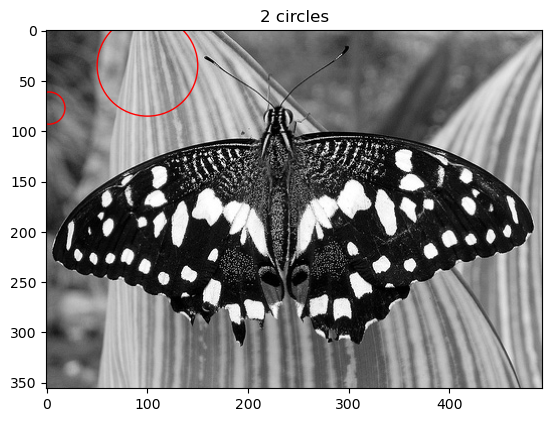

In [94]:
show_all_circles(images[0], [2,100], [77,35], [16,50])

[ 1.41421356  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356
  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356
  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356
  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356
  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356
  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356
  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356
  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356
  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356
  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356
  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356
  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356
  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356  1.41421356
  1.41421356  1.41421356  1.41421356  1.41421356  1

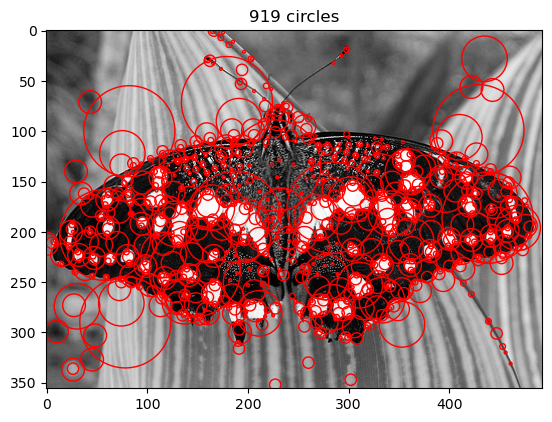

In [95]:
#np.set_printoptions(threshold=np.inf)

# print(x_coordinates)
# print(y_coordinates)
print(radii)

print(x_coordinates.max())
print(y_coordinates.max())

print(f"image size {images[0].shape}")
print(x_coordinates.shape, y_coordinates.shape, radii.shape)
show_all_circles(images[0], x_coordinates, y_coordinates, radii)
#show_all_circles(images[0], [55,33,88,10], [76,350,12,100], [5,7,1,2])

In [96]:
import cv2
import numpy as np

# Load your image
image = cv2.imread('images/butterfly.jpg', cv2.IMREAD_GRAYSCALE)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints, descriptors = sift.detectAndCompute(image, None)

# Print the radius (scale) of each keypoint
for kp in keypoints:
    print(f"Keypoint radius: {kp.size}")

print(f"number of keypoints {len(keypoints)}")


Keypoint radius: 7.039892673492432
Keypoint radius: 7.039892673492432
Keypoint radius: 9.89643383026123
Keypoint radius: 9.89643383026123
Keypoint radius: 9.936521530151367
Keypoint radius: 8.38396167755127
Keypoint radius: 11.6674165725708
Keypoint radius: 11.6674165725708
Keypoint radius: 10.20260238647461
Keypoint radius: 10.20260238647461
Keypoint radius: 5.025646686553955
Keypoint radius: 5.977290153503418
Keypoint radius: 8.488493919372559
Keypoint radius: 5.123463153839111
Keypoint radius: 5.123463153839111
Keypoint radius: 8.046290397644043
Keypoint radius: 9.387319564819336
Keypoint radius: 9.387319564819336
Keypoint radius: 7.613601207733154
Keypoint radius: 17.341140747070312
Keypoint radius: 14.746243476867676
Keypoint radius: 9.3104887008667
Keypoint radius: 14.199297904968262
Keypoint radius: 6.085587024688721
Keypoint radius: 6.085587024688721
Keypoint radius: 7.732848644256592
Keypoint radius: 9.687704086303711
Keypoint radius: 5.872124195098877
Keypoint radius: 9.58001